In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
import multiprocessing as mp
import emcee
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Leitura dos dados DESI BAO DR2
# =========================

# caminhos
bao_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/BAO/desi_gaussian_bao_ALL_GCcomb_mean.txt"
bao_cov_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/BAO/desi_gaussian_bao_ALL_GCcomb_cov.txt"

# tabela
df_bao = pd.read_csv(bao_dat_path, sep=r"\s+", comment="#", names=["z", "value", "quantity"])

# carregar covariancia
cov_bao = np.loadtxt(bao_cov_path)

# colunas z_bao e d_obs
z_bao = df_bao["z"].values
d_obs = df_bao["value"].values

# cálculo da matriz inversa
Cinv_bao = np.linalg.inv(cov_bao)

In [3]:
# =========================
# Fiducial
# =========================

# Priors uniformes
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
w_min, w_max = -3.0, 1.0

# Prios gaussianos
mu_Ob, sigma_Ob = 0.0495, 0.0025

# Constantes físicas
c_kms = 299792.458

# Parâmetros cosmológicos
Or0 = 7.881e-5
Neff = 3.04

# Grade
z_grid = np.linspace(0,4,1000)

In [4]:
# =========================
# Funções de Hubble
# =========================

def E_wCDM(z, Om0, w):
    Om = Om0 * (1 + z)**3
    Or = Or0 * (1 + z)**4
    Ode0 = 1 - Om0 - Or0
    Ode = Ode0 * (1 + z)**(3*(1 + w))
    return np.sqrt(Om + Or + Ode)

def H_wCDM(z, H0, Om0, w):
    return H0 * E_wCDM(z, Om0, w)

In [5]:
# ==============================
# Funções BAO
# ==============================

# Distância comóvel
def comoving_dist(z, H0, Om0, w):
    z_samples = np.linspace(0, z, 1000)
    y = 1.0 / E_wCDM(z_samples, Om0, w)
    integral = trapezoid(y, z_samples)
    return (c_kms / H0) * integral

# DM/rd
def DM_over_rd(z, H0, Om0, Ob, w):
    h2 = (H0 / 100)**2
    Obh2 = Ob * h2
    Omh2 = Om0 * h2
    rd = 147.05 * ((Obh2/0.02236 )**-0.13) * ((Omh2/0.1432)**-0.23) * ((Neff/3.04)**-0.1)
    dC = comoving_dist(z, H0, Om0, w)
    return dC / rd 

# DH/rd
def DH_over_rd(z, H0, Om0, Ob, w):
    h2 = (H0 / 100)**2
    Obh2 = Ob * h2
    Omh2 = Om0 * h2
    rd = 147.05 * ((Obh2/0.02236 )**-0.13) * ((Omh2/0.1432)**-0.23) * ((Neff/3.04)**-0.1)
    H_theo = H_wCDM(z, H0, Om0, w)
    return c_kms / (rd * H_theo)

# DV/rd
def DV_over_rd(z, H0, Om0, Ob, w):
    dm = DM_over_rd(z, H0, Om0, Ob, w)
    dh = DH_over_rd(z, H0, Om0, Ob, w)
    return (z * dm**2 * dh)**(1/3)


# ==============================
# Vetor BAO teórico
# ==============================
def d_theo(z, H0, Om0, Ob, w):

    d_model = []

    for _, row in df_bao.iterrows():
        z = row["z"]
        q = row["quantity"]

        if q == "DV_over_rs":
            d = DV_over_rd(z, H0, Om0, Ob, w)

        elif q == "DM_over_rs":
            d = DM_over_rd(z, H0, Om0, Ob, w)

        elif q == "DH_over_rs":
            d = DH_over_rd(z, H0, Om0, Ob, w)

        else:
            raise ValueError(f"Observável BAO desconhecido: {q}")

        d_model.append(d)

    return np.array(d_model)

print(d_theo(z_bao, 70, 0.3, 0.0495, -1.0))

[ 7.91976412 13.28342592 22.49262735 17.4442643  20.00919601 21.7100763
 17.4757763  27.77430236 14.03234388 29.96414406 12.86138692  8.62496068
 38.87042178]


In [6]:
# =========================================
# Likelihood DESI BAO DR2
# =========================================

# Priors
def lnprior_bao(theta_bao):
    H0, Om0, Ob, w = theta_bao
    
    # priors planos
    if not (H0_min < H0 < H0_max):     return -np.inf
    if not (Om0_min < Om0 < Om0_max):  return -np.inf
    if not (w_min <= w <= w_max):      return -np.inf

    # prior gaussiano em Ob
    lp_Ob = -0.5 * ((Ob - mu_Ob)**2 / sigma_Ob**2) - np.log(sigma_Ob * np.sqrt(2*np.pi))
    return lp_Ob


# Likelihood
def lnlike_bao(theta_bao, z_bao, d_obs, Cinv_bao):
    H0, Om0, Ob, w = theta_bao
    d_model = d_theo(z_bao, H0, Om0, Ob, w)
    delta = d_obs - d_model
    chi2_bao = np.dot(delta, np.dot(Cinv_bao, delta))
    return -0.5 * chi2_bao


# Posteriori
def lnprob_bao(theta_bao, z_bao, d_obs, Cinv_bao):
    lp = lnprior_bao(theta_bao)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_bao(theta_bao, z_bao, d_obs, Cinv_bao)


# Teste rápido
theta_bao_test = [70, 0.3, 0.0495, -1.0]
print(lnprob_bao(theta_bao_test, z_bao, d_obs, Cinv_bao))

-0.1684726504064793


In [7]:
# =========================
# MCMC
# =========================

ndim, nwalkers, nsteps, nburn = 4, 35, 45500, 3500
rng = np.random.default_rng(42)

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)         # H0 uniforme
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)       # Omega_m0 uniforme
p0[:,2] = rng.normal(mu_Ob, sigma_Ob, nwalkers)              # Ob gaussiano
p0[:,3] = rng.uniform(w_min, w_max, size=nwalkers)           # w uniforme

with mp.Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao), pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao))
# sampler.run_mcmc(p0, nsteps, progress=True)

# Pegando amostras após burn-in
flat_samples = sampler.get_chain(discard=nburn, flat=True)

# Cadeia completa: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
np.save("chain_wCDM_bao.npy", chain)

# Cadeia "achatada" (flat) após burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_wCDM_bao.npy", flat_samples)

100%|██████████| 45500/45500 [08:23<00:00, 90.43it/s] 


Removed no burn in


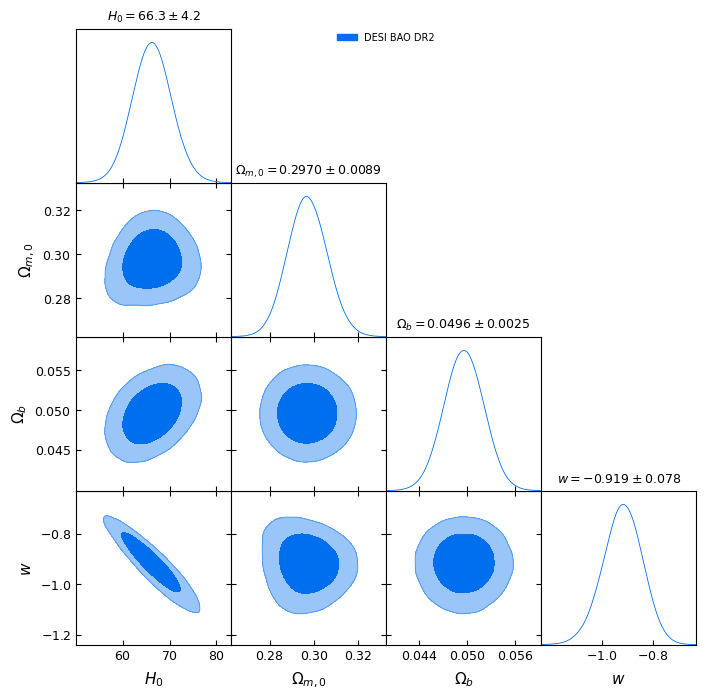

In [8]:
# =========================
# GetDist
# =========================

param_names  = ["H0", "Omega_m0", "Omega_b", "w"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"\Omega_b", r"w"]

samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})

# samples.setRanges({
#     "H0": (50, 90),
#     "Omega_m": (0.1, 0.6)
# })

g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3

# Triangle plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["DESI BAO DR2"],
    #contour_colors=["#"],
    title_limit=1
)

plt.savefig("triangle_wCDM_bao.png", dpi=300, bbox_inches="tight")
plt.show()